## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)



# **I. PFound**

Решение Яндекс

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd
import time

# считываем данные
qid_query = pd.read_csv("/content/drive/MyDrive/YandexCup/hidden_task/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("/content/drive/MyDrive/YandexCup/hidden_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("/content/drive/MyDrive/YandexCup/hidden_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])

In [4]:
# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")
qid_url_rating_hostid.head()

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53


In [5]:
def plook(ind, rels):
  if ind == 0:
    return 1
  return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)

In [6]:
def pfound(group):
  max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
  top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
  pfound = 0
  for ind, val in enumerate(top10):
    pfound += val*plook(ind, top10.values)
  return pfound

In [7]:
qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_pfound

qid
5308      0.415820
48815     0.655448
49587     0.493599
55082     0.497771
58989     0.497771
60304     0.735836
63179     0.460028
70357     0.655448
70618     0.263596
79514     0.764755
91889     0.344494
99543     0.772245
402111    0.324649
405851    0.718072
407522    0.460028
409073    0.808643
438518    0.497771
690263    0.770353
692059    0.655448
692308    0.852628
dtype: float64

In [8]:
qid_max = qid_pfound.idxmax() # берем qid с максимальным pfound
qid_query[qid_query["qid"] == qid_max]

,qid,query
14,692308,бесплатный просмотр камеди клаб


In [9]:
qid_pfound.mean()

0.5822199638393889

Решение без цикла

In [10]:
def pfound_mean(df, p_Break = 0.15, k = 10):
  # Максимальный рейтинг
  qid_max_by_host = df.groupby(['qid', 'hostid'])['rating'].max().reset_index() 
	# Сортировка данных и берем топ10 док-ов для одного qid
  top_k = qid_max_by_host.sort_values(['qid', 'rating'], ascending=False).groupby(['qid']).head(k)
	# Нумерация для каждого qid
  top_k['rank'] = top_k.groupby('qid').cumcount() + 1
	# Расчитываем коэффициент * (1 - pRel)
  top_k['one_rel'] = (1 - top_k['rating']).shift(1) * (1 - p_Break)
  top_k.loc[top_k['rank'] == 1, ['one_rel']] = 1	
	# Расчитываем pLook
  top_k['plook'] = top_k.groupby('qid')['one_rel'].cumprod() 	
	# Расчитываем pFound
  top_k['pfound'] = top_k['plook'] * top_k['rating']
	# Возвращаем pFound mean
  return top_k.groupby('qid')['pfound'].sum().mean()

In [11]:
pfound_mean(qid_url_rating_hostid)

0.5822199638393889

Сравнение времени работы решения от Yandex с нашим

In [21]:
# yandex
start_time = time.time()
pfound_yandex = qid_pfound.mean()
diff_times_ya = time.time() - start_time

# Team12
start_time = time.time()
pfound_our = pfound_mean(qid_url_rating_hostid)
diff_times_our = time.time() - start_time

print(f'Значения pfound | Yandex: {qid_pfound.mean()}, Team12: {pfound_mean(qid_url_rating_hostid)}')
print(f'Время работы pfound | Yandex: {diff_times_ya}, Team12: {diff_times_our}')

Значения pfound | Yandex: 0.5822199638393889, Team12: 0.5822199638393889
Время работы pfound | Yandex: 0.0005805492401123047, Team12: 0.021229982376098633


# **II. MRR**

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

Импорт библиотек

In [22]:
!pip3 install rectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 10.7 MB/s 
     |████████████████████████████████| 310 kB 53.5 MB/s 
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 13.4 MB 35.5 MB/s 
     |████████████████████████████████| 60 kB 6.1 MB/s 
     |████████████████████████████████| 188 kB 72.3 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp38-cp38-linux_x86_64.whl size=3825474 sha256=ae9f10f5dad5db13fe698670e45f2d20e5b79b2330a679f0cd9928670fd92ffa
  Stored in directory: /root/.cache/pip/wheels/00/ac/67/6f4536c819ed560c2c7e17c0f7a920e3e50c26108616087d05
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=746149 sha256=0effd64f490c78629f59150f729ee5a47088d11727de299e94d6ee8f39227d1d
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021

In [23]:
import pandas as pd
import numpy as np
import numba as nb

from tqdm.auto import tqdm
from rectools import Columns

In [24]:
np.random.seed(23)

Подключение Google Disk

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка данных

In [26]:
interactions = pd.read_csv('/content/drive/MyDrive/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [27]:
users = pd.read_csv('/content/drive/MyDrive/users.csv')
items = pd.read_csv('/content/drive/MyDrive/items.csv')

In [28]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [29]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


Выделим небольшой кусок из данных, чтобы не слишком страдать

In [30]:
sample_users = [57607, 403227, 70720]
df = interactions[interactions[Columns.User].isin(sample_users)].reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [31]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)

Users [ 70720  57607 403227]
Items [ 4880  4151 10440  4881  6353  1736  6327 13865  5336   181]


Функция генерации выборки

In [32]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [33]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

NAIVE

In [74]:
def mrr_naive(target, users, recs, top_k):
    mrr = 0
    for i, j in enumerate(users):
        res = 0
        user_target = target[target[:, 0] == j][:, 1]
        for k, rec in enumerate(recs[i][:top_k]):
            if rec in user_target:
                res = 1 / (k + 1)
                break
        mrr += res
    return mrr / len(users)

NUMBA

In [78]:
@nb.njit(cache=True, parallel=True, nopython=False)
def mrr_numba(target, users, recs, top_k):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for k, rec in enumerate(recs[i][:top_k]):
            if rec in user_target:
                p = 1 / (k + 1)
                break
        mrr[i] = p
    return mrr.mean()

/usr/local/lib/python3.8/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


PANDAS

In [36]:
def mrr_pandas(df, users, recs, top_k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, top_k),
        Columns.Item: recs.ravel()
        })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    k = df_recs.groupby(Columns.User)[Columns.Rank].agg('min')
    mrr = (1/k).sum() / len(k)
    
    return mrr

Проверка результатов метрик и измерение времени работы

In [38]:
import matplotlib.pyplot as plt
import time
import timeit

In [79]:
print(f'MRR Naive: {mrr_naive(target, users, recs, top_k)}')
print(f'MRR Numba: {mrr_numba(target, users, recs, top_k)}')
print(f'MRR Pandas: {mrr_pandas(df, users, recs, top_k)}')

MRR Naive: 0.07836801587301619
MRR Numba: 0.07836801587301577
MRR Pandas: 0.07836801587301587


In [80]:
%timeit mrr_naive(target, users, recs, top_k)

1.77 s ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
%timeit mrr_numba(target, users, recs, top_k)

1.12 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%timeit mrr_pandas(df, users, recs, top_k)

52.5 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Протестируйте для всех комбинаций

In [83]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
time_naive = []
time_numba = []
time_pandas = []
for user in tqdm(users_count):
  for i in top_k:
    df, users, recs = generate_subsample(user, i)
    target = df.values
    start_time = time.time()
    mrr_naive(target, users, recs, i)
    time_naive.append((time.time() - start_time))    
    start_time = time.time()
    mrr_numba(target, users, recs, i)
    time_numba.append((time.time() - start_time))    
    start_time = time.time()
    mrr_pandas(df, users, recs, i)
    time_pandas.append((time.time() - start_time))

  0%|          | 0/4 [00:00<?, ?it/s]

In [84]:
t_naive = np.array(time_naive).reshape((4, 3))
t_numba = np.array(time_numba).reshape((4, 3))
t_pandas = np.array(time_pandas).reshape((4, 3))

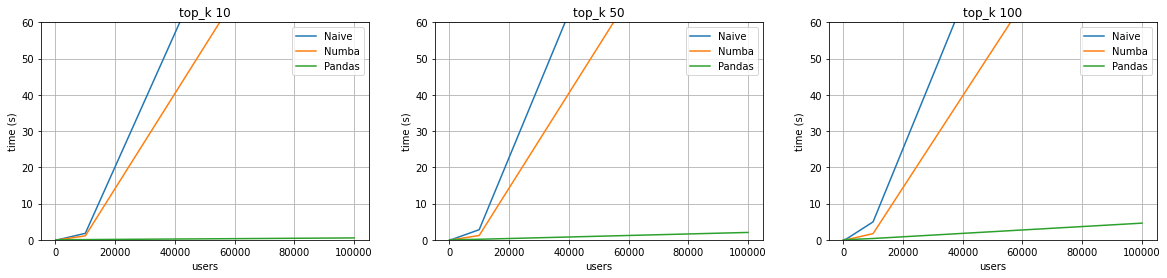

In [85]:
graf, ax = plt.subplots(1,3, figsize=(20,4))
for i in range(3):
  ax[i].plot(users_count, t_naive[:,i], label='Naive')
  ax[i].plot(users_count, t_numba[:,i], label='Numba')
  ax[i].plot(users_count, t_pandas[:,i], label='Pandas')
  ax[i].set_xlabel('users')
  ax[i].set_ylabel('time (s)')
  ax[i].set_title(f'top_k {top_k[i]}')
  ax[i].set_ylim(0, 60)
  ax[i].grid()
  ax[i].legend()
plt.show()

In [86]:
t2_naive = np.array(time_naive).reshape((3, 4))
t2_numba = np.array(time_numba).reshape((3, 4))
t2_pandas = np.array(time_pandas).reshape((3, 4))

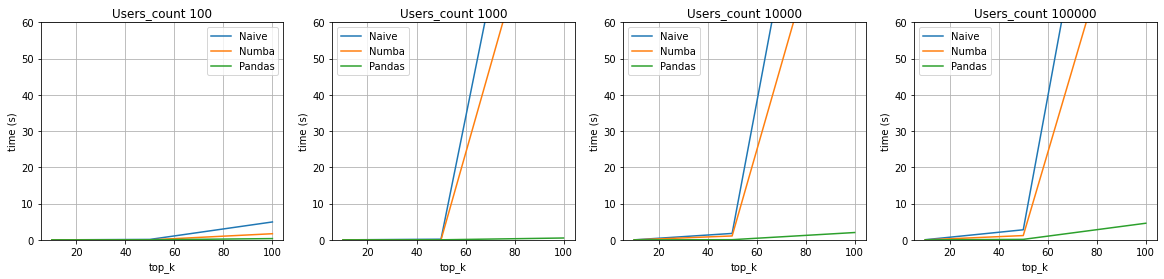

In [87]:
graf, ax = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
  ax[i].plot(top_k, t2_naive[:,i], label='Naive')
  ax[i].plot(top_k, t2_numba[:,i], label='Numba')
  ax[i].plot(top_k, t2_pandas[:,i], label='Pandas')
  ax[i].set_xlabel('top_k')
  ax[i].set_ylabel('time (s)')
  ax[i].set_title(f'Users_count {users_count[i]}')
  ax[i].set_ylim(0, 60)
  ax[i].grid()
  ax[i].legend()
plt.show()